In [3]:
import kwant
import numpy as np
import matplotlib.pyplot as pyplot
import tinyarray
%matplotlib inline
import scipy
from tqdm.notebook import tqdm

C:\Users\caidi\Anaconda3\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [4]:
hamiltonian = """
vf*(k_y*kron(sigma_0,sigma_x) - k_x*kron(sigma_0,sigma_y))+ (m0-m1*(k_x**2+k_y**2))*kron(sigma_z,sigma_z) + Mz(x,y)*kron(sigma_0,sigma_z)
"""

In [14]:
a = 1
W = 25
L = 25
template = kwant.continuum.discretize(hamiltonian,grid = a)
lat = template.lattice
def shape(site):
    (x,y) = site.pos
    return (0 <= y <W and 0 <=x <L)
def lead_shape_sd(site):
    (x,y) = site.pos
    return (0 <= y<W)
def lead_shape_2(site):
    (x,y) = site.pos
    return (L/5 <= x<L*2/5)
def lead_shape_3(site):
    (x,y) = site.pos
    return (3*L/5 <= x<L*4/5)
def lead_shape_5(site):
    (x,y) = site.pos
    return (L/5<=x<L*4/5)


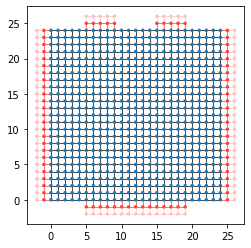

In [15]:
syst = kwant.Builder()
syst.fill(template,shape,(0,0))

lead1 = kwant.Builder(kwant.TranslationalSymmetry([-a,0]))
lead1.fill(template,lead_shape_sd,(0,0))
lead2 = kwant.Builder(kwant.TranslationalSymmetry([0,a]))
lead2.fill(template,lead_shape_2,(L/5,0))
lead3 = kwant.Builder(kwant.TranslationalSymmetry([0,a]))
lead3.fill(template,lead_shape_3,(L*3/5,0))
lead4 = lead1.reversed()
lead5 = kwant.Builder(kwant.TranslationalSymmetry([0,-a]))
lead5.fill(template,lead_shape_5,(L/5,0))
                                 
syst.attach_lead(lead1)
syst.attach_lead(lead2)
syst.attach_lead(lead3)
syst.attach_lead(lead4)
syst.attach_lead(lead5)

kwant.plot(syst)
syst=syst.finalized()

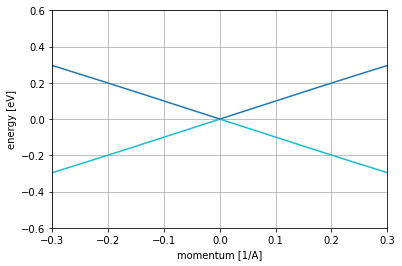

In [16]:
def Mz(x,y):
    return 3
params = {'vf':1,'m1':1,'m0':-0.5,'Mz':Mz}
kwant.plotter.bands(syst.leads[4],params = params, momenta = np.linspace(-0.3,0.3,201), show = False)
pyplot.grid()
pyplot.xlim(-.3, 0.3)
pyplot.ylim(-0.6,0.6)
pyplot.xlabel('momentum [1/A]')
pyplot.ylabel('energy [eV]')
pyplot.show()

In [86]:
nnls=scipy.optimize.nnls
energies = np.linspace(-1,1,100)
dataxx = []
dataxy = []
for energy in tqdm(energies):
    smatrix = kwant.smatrix(syst,energy,params = params)
    R = nnls(smatrix.conductance_matrix(),np.array((1,0,0,-1,0)))[0]
    dataxy.append(R[1]-R[4])
    dataxx.append(R[1]-R[2])

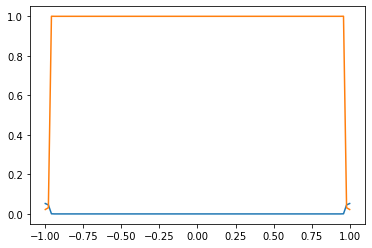

In [87]:
pyplot.figure()
pyplot.plot(energies,dataxx,energies,dataxy)
pyplot.show()

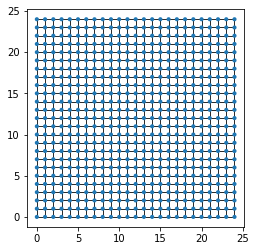

Wall time: 1.52 s


In [21]:
%%time
a = 1
r = 30
template = kwant.continuum.discretize(hamiltonian,grid = a)
lat = template.lattice
def circle(site):
    x,y = site.pos
    return (x**2 + y**2 <= r**2)
def rect(site):
    x,y= site.pos
    return (0 <= y <W and 0 <=x <L)
syst = kwant.Builder()
syst.fill(template,rect,(0,0))
syst.eradicate_dangling()
kwant.plot(syst)
syst_without_lead = syst.finalized()



where = lambda s : np.linalg.norm(s.pos)<1.1


s_factory = kwant.kpm.LocalVectors(syst_without_lead)
cond_xx = kwant.kpm.conductivity(syst_without_lead, alpha = 'x',beta = 'x',params=params)
s_factory = kwant.kpm.LocalVectors(syst_without_lead)
cond_xy = kwant.kpm.conductivity(syst_without_lead, alpha = 'x',beta = 'y',params=params)
energies = np.linspace(-2,2,200)
#energies = cond_xx.energies
cond_array_xx = np.array([cond_xx(e,temperature = 1E-6) for e in energies])
cond_array_xy = np.array([cond_xy(e,temperature = 1E-6) for e in energies])
cond_array_xx/=W*L
cond_array_xy/=W*L

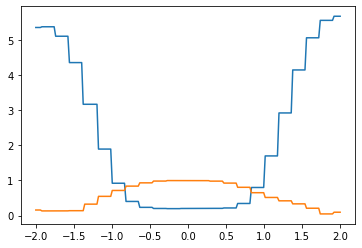

In [18]:
fig,ax = pyplot.subplots()
plt = ax.plot(energies,np.abs(cond_array_xx),energies,np.abs(cond_array_xy))

In [79]:
ax.set_xlim([-1,1])

(-1, 1)

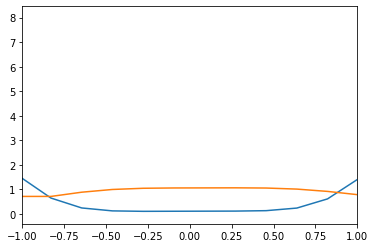

In [80]:
fig